# 日経平均株価 日足

In [1]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

symbol = '^N225'
ticker = yf.Ticker(symbol)

df = ticker.history(period='6mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-07-17 00:00:00+09:00,41416.179688,41466.449219,41054.718750,41097.691406,109900000,0.0,0.0
2024-07-18 00:00:00+09:00,40521.710938,40587.628906,40104.218750,40126.351562,117600000,0.0,0.0
2024-07-19 00:00:00+09:00,39965.910156,40212.898438,39824.578125,40063.789062,99800000,0.0,0.0
2024-07-22 00:00:00+09:00,39947.949219,39973.199219,39519.390625,39599.000000,82700000,0.0,0.0
2024-07-23 00:00:00+09:00,39864.089844,39927.890625,39519.910156,39594.390625,88300000,0.0,0.0
...,...,...,...,...,...,...,...
2025-01-10 00:00:00+09:00,39550.250000,39591.460938,39166.050781,39190.398438,113200000,0.0,0.0
2025-01-14 00:00:00+09:00,39010.960938,39054.351562,38305.910156,38474.300781,126900000,0.0,0.0
2025-01-15 00:00:00+09:00,38721.609375,38774.988281,38316.011719,38444.578125,100700000,0.0,0.0


## パラボリック SAR

In [2]:
def psar(ohlc: pd.DataFrame, iaf: float = 0.02, maxaf: float = 0.2) -> dict:
    length = len(ohlc)
    high = ohlc['High'].tolist()
    low = ohlc['Low'].tolist()
    close = ohlc['Close'].tolist()
 
    psar = close[0:len(close)]
    psarbull = [None] * length
    psarbear = [None] * length
 
    bull = True
    af = iaf
    ep = low[0]
    price_high = high[0]
    price_low = low[0]
 
    for i in range(2, length):
        if bull:
            psar[i] = psar[i - 1] + af * (price_high - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (price_low - psar[i - 1])
        reverse = False
 
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = price_high
                price_low = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = price_low
                price_high = high[i]
                af = iaf
 
        if not reverse:
            if bull:
                if high[i] > price_high:
                    price_high = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < price_low:
                    price_low = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]
 
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
 
    return {
        'bear': np.array(psarbear, dtype='float64'),
        'bull': np.array(psarbull, dtype='float64'),
    }

## 日足チャートとパラボリック SAR

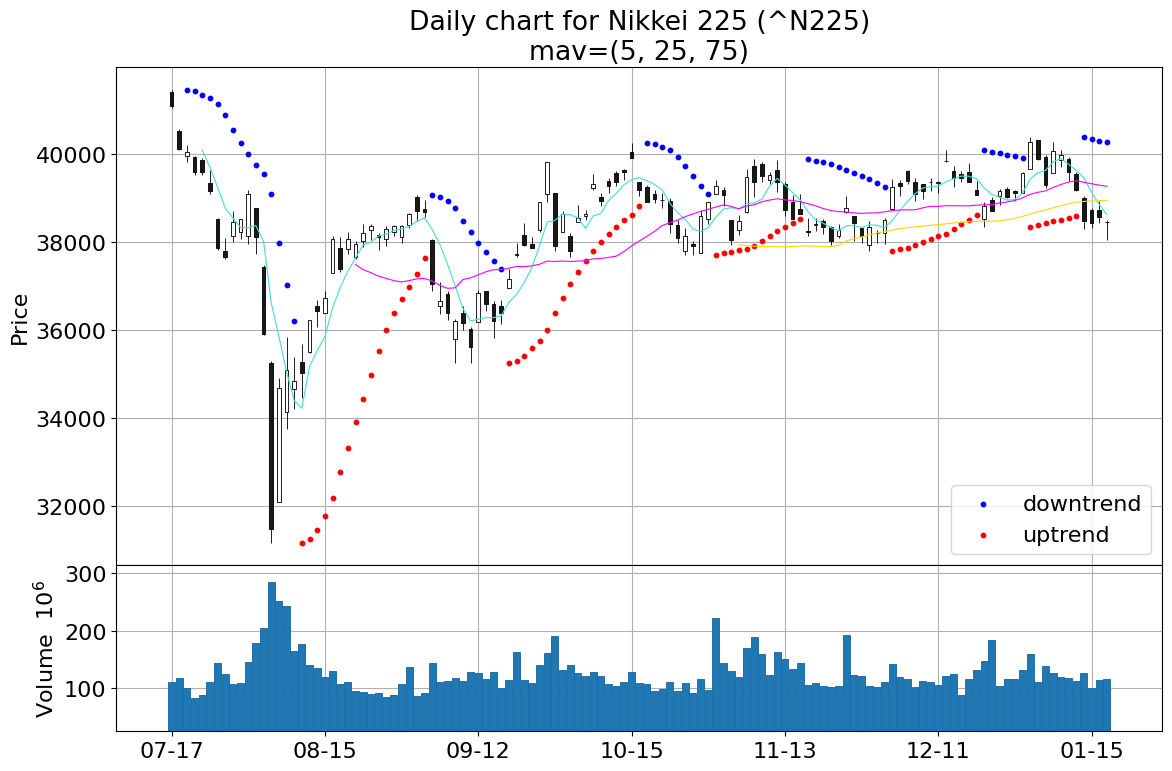

In [3]:
dict_psar = psar(df)

plt.rcParams["font.size"] = 16
fig = plt.figure(figsize=(12, 8))
#ax = fig.add_subplot(111)
ax = dict()
n = 2
gs = fig.add_gridspec(
    n, 1,
    wspace=0.0, hspace=0.0,
    height_ratios=[3 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex='col')):
    ax[i] = axis
    ax[i].grid()

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=10,
        color='blue',
        label='downtrend',
        ax=ax[0]
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=10,
        color='red',
        label='uptrend',
        ax=ax[0]
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=ax[1],
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax[0],
)
try:
    ax[0].set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax[0].set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

#ax.grid()

plt.tight_layout()
plt.savefig('daily_chart_n225.png')
plt.show()

In [4]:
df.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-01-17 00:00:00+09:00,38454.101562,38503.941406,38055.679688,38451.460938,115300000,0.0,0.0


In [5]:
df.tail(2)['Close']

Date
2025-01-16 00:00:00+09:00    38572.601562
2025-01-17 00:00:00+09:00    38451.460938
Name: Close, dtype: float64

In [6]:
df.tail(2)['Close'].diff()

Date
2025-01-16 00:00:00+09:00           NaN
2025-01-17 00:00:00+09:00   -121.140625
Name: Close, dtype: float64

In [7]:
df['Close'].rolling(25).mean()

Date
2024-07-17 00:00:00+09:00             NaN
2024-07-18 00:00:00+09:00             NaN
2024-07-19 00:00:00+09:00             NaN
2024-07-22 00:00:00+09:00             NaN
2024-07-23 00:00:00+09:00             NaN
                                 ...     
2025-01-10 00:00:00+09:00    39395.621875
2025-01-14 00:00:00+09:00    39364.639531
2025-01-15 00:00:00+09:00    39331.367031
2025-01-16 00:00:00+09:00    39298.447031
2025-01-17 00:00:00+09:00    39272.858594
Name: Close, Length: 123, dtype: float64

In [8]:
df['Close'].rolling(75).mean()

Date
2024-07-17 00:00:00+09:00             NaN
2024-07-18 00:00:00+09:00             NaN
2024-07-19 00:00:00+09:00             NaN
2024-07-22 00:00:00+09:00             NaN
2024-07-23 00:00:00+09:00             NaN
                                 ...     
2025-01-10 00:00:00+09:00    38909.927448
2025-01-14 00:00:00+09:00    38927.513750
2025-01-15 00:00:00+09:00    38937.122656
2025-01-16 00:00:00+09:00    38945.549479
2025-01-17 00:00:00+09:00    38953.298802
Name: Close, Length: 123, dtype: float64